# Flow Matching: Learning to Transform Distributions

This notebook introduces the fundamental concept of **Flow Matching**, a powerful technique for training continuous normalizing flows (CNFs). We'll build a simple model from scratch to learn a transformation from a simple Gaussian (normal) distribution to a more complex checkerboard pattern.

**The core takeaway of this tutorial is to understand how Flow Matching learns the overall transformation of a distribution, rather than just memorizing the specific training data points.** This allows the trained model to successfully transform any sample from the source distribution into the target distribution, even if that specific sample was never seen during training. This is achieved by training the model on a regression task that learns the *expected value* of the conditional velocity field, which in turn approximates the true velocity field of the probability flow.


## 1. What is Flow Matching?

Imagine you have a pile of sand in one shape (our source distribution, $p_0$) and you want to move all the grains to form a different shape (our target distribution, $p_1$). Flow Matching is a method to learn the "wind" (a velocity field) that will blow each grain of sand from its initial position to its final position along a smooth path.

This "wind" is defined by a differential equation called the **probability flow ODE**:

$$
\frac{\mathrm{d}\mathbf{x}_t}{\mathrm{d}t} = \mathbf{v}_t(\mathbf{x}_t),
$$

where:

- $\mathbf{x}_t$ is the position of a particle at time $t$,
- $\mathbf{v}_t(\mathbf{x}_t)$ is the velocity at position $\mathbf{x}_t$ and time $t$,
- we start at $t=0$ with points from $p_0$ and end at $t=1$ with points from $p_1$.

The challenge is that the true velocity field $\mathbf{v}_t$ is very complex and depends on the entire distribution at time $t$. Flow Matching provides a clever way to learn this field using a simple regression objective.


### The Key Idea

Instead of trying to compute the complex $\mathbf{v}_t$ directly, Flow Matching does the following:

1. Define a simple, straight-line path between a point $\mathbf{x}_0 \sim p_0$ and a point $\mathbf{x}_1 \sim p_1$. The point on this path at time $t$ is
$$
\mathbf{x}_t = (1-t)\,\mathbf{x}_0 + t\,\mathbf{x}_1.
$$
2. The velocity along this *specific* straight path is constant and easy to calculate:
$$
\mathbf{u}_t(\mathbf{x}_t\mid\mathbf{x}_0,\mathbf{x}_1) = \mathbf{x}_1 - \mathbf{x}_0,
$$
which we call the *conditional* velocity field for this pair.
3. Train a neural network $\mathbf{v}_\theta(\mathbf{x}, t)$ to predict this velocity from the interpolated point $\mathbf{x}_t$ and time $t$.

If we train on many randomly paired samples $(\mathbf{x}_0, \mathbf{x}_1)$, the network learns the **expected** conditional velocity at each space–time location $(\mathbf{x}, t)$. Under suitable conditions, this expectation matches the true marginal probability–flow field:
$$
\mathbb{E}_{\mathbf{x}_0\sim p_0,\,\mathbf{x}_1\sim p_1}\big[\,\mathbf{u}_t(\mathbf{x}\mid\mathbf{x}_0,\mathbf{x}_1)\,\big] 
= \mathbf{v}_t(\mathbf{x}).
$$
This is why Flow Matching is powerful: it learns the global *flow* of the distribution, not just how to move specific training points.


## 2. Setup and Imports

We will use `torch` for building and training the model, `numpy` for data manipulation, and `matplotlib` for visualization.


In [19]:
import tqdm
import math
import torch
import numpy as np
from torch import nn
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# For reproducibility (optional)
torch.manual_seed(0)
np.random.seed(0)


## 3. Preparing the Data

We'll start with a standard normal distribution (a 2D Gaussian centered at zero) as our source, $p_0$. Our target, $p_1$, will be a checkerboard pattern. We will sample a finite number of points, `N`, from this checkerboard pattern to serve as our training data.

The code below generates this checkerboard pattern and samples `N` points from the "yellow" squares.


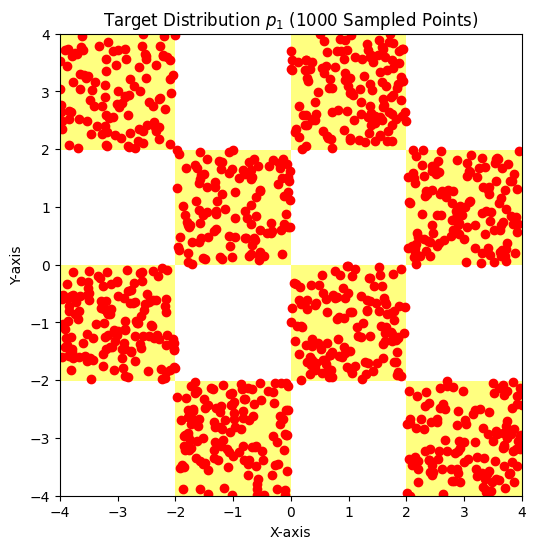

In [20]:
# Parameters
N = 1000  # Number of points to sample
x_min, x_max = -4, 4
y_min, y_max = -4, 4
resolution = 100  # Resolution of the grid

# Create the grid
x_grid = np.linspace(x_min, x_max, resolution)
y_grid = np.linspace(y_min, y_max, resolution)
X, Y = np.meshgrid(x_grid, y_grid)

# Checkerboard pattern
length = 4
checkerboard = np.indices((length, length)).sum(axis=0) % 2

# Sample points in regions where checkerboard pattern is 1
sampled_points = []
while len(sampled_points) < N:
    x_sample = np.random.uniform(x_min, x_max)
    y_sample = np.random.uniform(y_min, y_max)

    # Determine the closest grid index (clamp to valid range)
    i = int((x_sample - x_min) / (x_max - x_min) * length)
    j = int((y_sample - y_min) / (y_max - y_min) * length)
    i = max(0, min(length - 1, i))
    j = max(0, min(length - 1, j))

    if checkerboard[j, i] == 1:
        sampled_points.append((x_sample, y_sample))

sampled_points = np.array(sampled_points)

# Plot the checkerboard pattern + sampled points
plt.figure(figsize=(6, 6))
plt.imshow(checkerboard, extent=(x_min, x_max, y_min, y_max), origin="lower", cmap=ListedColormap(["white", "yellow"]), alpha=0.5)
plt.scatter(sampled_points[:, 0], sampled_points[:, 1], color="red", marker="o")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.title(f"Target Distribution $p_1$ ({N} Sampled Points)")
plt.show()


## 4. The Velocity-Field Model (Neural Network)

We use a simple multi-layer perceptron (MLP) to model the velocity field $\mathbf{v}_\theta(\mathbf{x}, t)$. The network takes two inputs: the current position $\mathbf{x}$ and the current time $t$.
To help the network represent time, we employ sinusoidal time embeddings (popularized by Transformers), which map the scalar $t$ to a higher-dimensional vector.


In [21]:
class Block(nn.Module):
    def __init__(self, channels=512):
        super().__init__()
        self.ff = nn.Linear(channels, channels)
        self.act = nn.SiLU()

    def forward(self, x):
        return self.act(self.ff(x))


class MLP(nn.Module):
    def __init__(self, channels_data=2, layers=5, channels=512, channels_t=512):
        super().__init__()
        self.channels_t = channels_t
        # Projects input data and time to the main channel dimension
        self.in_projection = nn.Linear(channels_data, channels)
        self.t_projection = nn.Linear(channels_t, channels)

        # A sequence of residual blocks
        self.blocks = nn.Sequential(*[
            Block(channels) for _ in range(layers)
        ])

        # Projects the result back to the data dimension (2D velocity)
        self.out_projection = nn.Linear(channels, channels_data)

    def gen_t_embedding(self, t, max_positions=10000):
        """Generates sinusoidal time embeddings."""
        t = t * max_positions
        half_dim = self.channels_t // 2
        emb = math.log(max_positions) / (half_dim - 1)
        emb = torch.arange(half_dim, device=t.device).float().mul(-emb).exp()
        emb = t[:, None] * emb[None, :]
        emb = torch.cat([emb.sin(), emb.cos()], dim=1)
        if self.channels_t % 2 == 1:  # zero-pad if channels_t is odd
            emb = nn.functional.pad(emb, (0, 1), mode='constant')
        return emb

    def forward(self, x, t):
        # 1) Project input data
        x = self.in_projection(x)
        # 2) Generate and project time embeddings
        t_emb = self.gen_t_embedding(t)
        t_proj = self.t_projection(t_emb)
        # 3) Add time information to the data representation
        x = x + t_proj
        # 4) Pass through the main network blocks
        x = self.blocks(x)
        # 5) Project back to the output dimension
        x = self.out_projection(x)
        return x


## 5. The Training Loop

Each step:
1. **Sample $\mathbf{x}_1$** from $p_1$ (checkerboard samples);
2. **Sample $\mathbf{x}_0$** from $p_0$ (standard Gaussian);
3. **Define target velocity** as $\mathbf{x}_1-\mathbf{x}_0$;
4. **Sample $t\sim\mathcal{U}(0,1)$** and compute $\mathbf{x}_t=(1-t)\,\mathbf{x}_0+t\,\mathbf{x}_1$;
5. **Predict** $\hat{\mathbf{u}}=\mathbf{v}_\theta(\mathbf{x}_t,t)$ and minimize MSE to the target.


Using device: cuda


100%|██████████| 5000/5000 [00:22<00:00, 225.64it/s, loss=3.48]


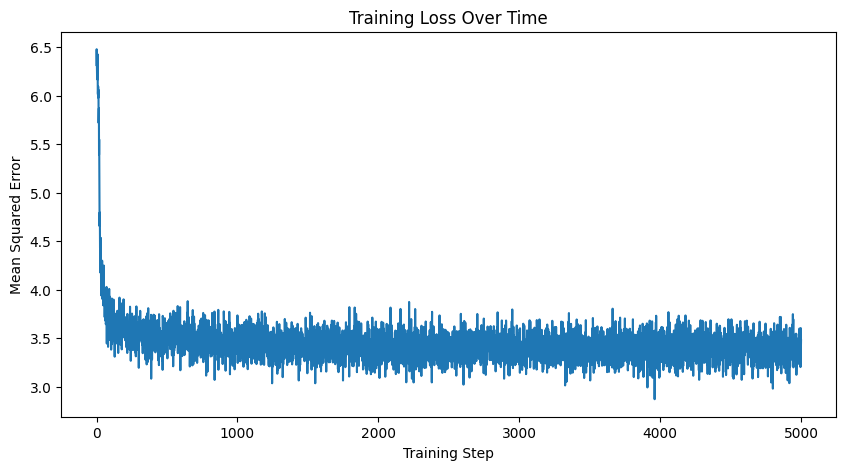

In [22]:
# Setup device, model, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

model = MLP(layers=5, channels=512).to(device)
optim = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=0.1)

# Convert data to a tensor
data = torch.tensor(sampled_points, dtype=torch.float32)

# Training parameters
training_steps = 5000
batch_size = 1024

pbar = tqdm.tqdm(range(training_steps))
losses = []

for _ in pbar:
    # 1) Sample x1 from the target distribution p1
    idx = torch.randint(data.size(0), (batch_size,))
    x1 = data[idx].to(device)

    # 2) Sample x0 from the source distribution p0 (Standard Normal)
    x0 = torch.randn_like(x1, device=device)

    # 3) Target velocity for the straight path
    target = x1 - x0

    # 4) Sample a random time t ~ U(0, 1)
    t = torch.rand(x1.size(0), device=device)

    # 5) Interpolated point x_t
    xt = (1 - t[:, None]) * x0 + t[:, None] * x1

    # 6) Model prediction and optimization
    pred = model(xt, t)
    loss = ((target - pred) ** 2).mean()
    loss.backward()
    optim.step()
    optim.zero_grad()
    pbar.set_postfix(loss=float(loss))
    losses.append(float(loss))

# Plot the training loss
plt.figure(figsize=(10, 5))
plt.plot(losses)
plt.title("Training Loss Over Time")
plt.xlabel("Training Step")
plt.ylabel("Mean Squared Error")
plt.show()


## 6. Inference and Visualization

With our model trained, we simulate the learned flow by starting from fresh points sampled from $p_0$ and integrating the predicted velocity field forward in time.

We use explicit Euler integration:
$$
\mathbf{x}_{t+\Delta t} = \mathbf{x}_t + \Delta t\,\mathbf{v}_\theta(\mathbf{x}_t, t).
$$


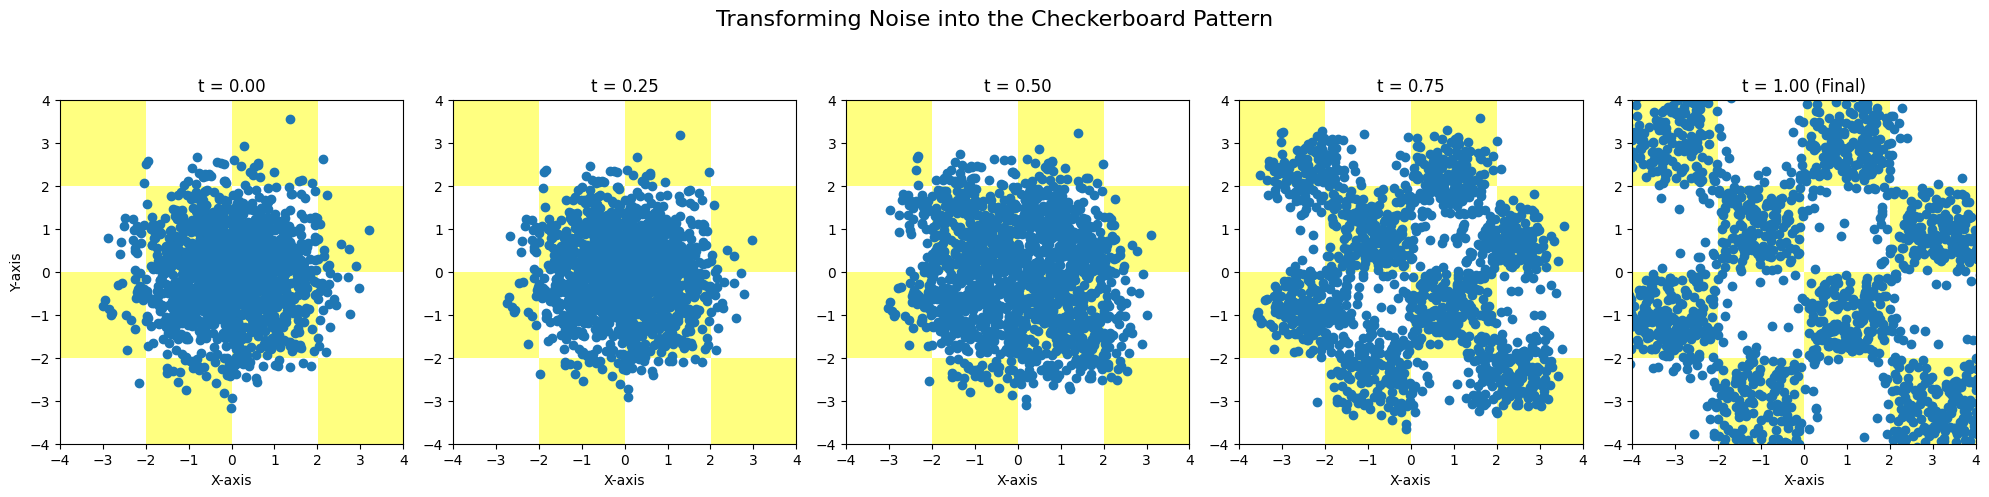

In [23]:
def grab(var):
    """Move a tensor to CPU and convert to numpy."""
    return var.detach().cpu().numpy()

# Evaluation mode
model.eval().requires_grad_(False)

# Sample 1500 new points from p0
xt = torch.randn(1500, 2, device=device)

# Simulation parameters
steps = 1000
plot_every = 250  # plot 4 snapshots

# Store intermediate point clouds for plotting
trajectory = [grab(xt)]

# Integrate from t=0 to t=1
for i, t_val in enumerate(torch.linspace(0, 1, steps, device=device), start=1):
    t = torch.full((xt.size(0),), float(t_val), device=device)
    pred = model(xt, t)
    xt = xt + (1.0 / steps) * pred  # Euler step
    if i % plot_every == 0:
        trajectory.append(grab(xt))

# Plot the results
fig, axes = plt.subplots(1, len(trajectory), figsize=(20, 5))
titles = [f't = {i/4:.2f}' for i in range(len(trajectory))]
titles[-1] = 't = 1.00 (Final)'

for ax, points, title in zip(axes, trajectory, titles):
    ax.imshow(checkerboard, extent=(x_min, x_max, y_min, y_max), origin="lower", cmap=ListedColormap(["white", "yellow"]), alpha=0.5)
    ax.scatter(points[:, 0], points[:, 1])
    ax.set_title(title)
    ax.set_xlabel("X-axis")
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)

axes[0].set_ylabel("Y-axis")
plt.suptitle("Transforming Noise into the Checkerboard Pattern", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Switch back if you plan to continue training
# model.train().requires_grad_(True)


## 7. Animating the Flow

To visualize the continuous transformation, we build an animation of the forward integration from $t=0$ to $t=1$.


In [ ]:
def create_animation(model, num_points=1000, num_frames=100, pause_frames=30):
    """Create and return an animation of the flow-matching process."""
    model.eval().requires_grad_(False)

    # 1) Fresh noise samples from p0
    x_t = torch.randn(num_points, 2, device=device)

    # Record history
    x_history = [grab(x_t)]

    # 2) Integrate forward
    dt = 1.0 / num_frames
    for t_val in torch.linspace(0, 1, num_frames, device=device):
        t = torch.full((x_t.size(0),), float(t_val), device=device)
        pred = model(x_t, t)
        x_t = x_t + pred * dt
        x_history.append(grab(x_t))

    final_state = x_history[-1]
    for _ in range(pause_frames):
        x_history.append(final_state.copy())

    model.train().requires_grad_(True)

    # 3) Build animation
    fig, ax = plt.subplots(figsize=(6, 6))

    def animate(i):
        ax.clear()
        ax.imshow(checkerboard, extent=(x_min, x_max, y_min, y_max), origin="lower", cmap=ListedColormap(["white", "yellow"]), alpha=0.5)
        points = x_history[i]
        ax.scatter(points[:, 0], points[:, 1])
        ax.set_xlim([x_min, x_max])
        ax.set_ylim([y_min, y_max])
        if i/num_frames <= 1.0:
            ax.set_title(f"Flow Matching Animation: t = {i/num_frames:.2f}")
        else:
            ax.set_title(f"Flow Matching Animation: t = 1.00")
        ax.set_xlabel("X-axis")
        ax.set_ylabel("Y-axis")

    anim = FuncAnimation(fig, animate, frames=len(x_history), interval=50)
    plt.close(fig)
    return anim

print("Generating animation preview...")
animation = create_animation(model, num_points=5000, num_frames=60)
# animation.save('flow_matching_animation.gif', writer='pillow', fps=20)
HTML(animation.to_jshtml())


## 8. Conclusion

In this notebook, we:

1. Defined a source (Gaussian) and target (Checkerboard) distribution;
2. Built a simple neural network to act as a velocity field;
3. Trained the network using the Flow Matching objective (regressing $\mathbf{x}_1-\mathbf{x}_0$ at interpolated points $\mathbf{x}_t$);
4. Visualized how this learns the global transformation required to map the source distribution to the target.

The key insight is that random pairing $(\mathbf{x}_0,\mathbf{x}_1)$ forces the model to learn the **expected** conditional velocity at any $(\mathbf{x}, t)$, which corresponds to the probability-flow field of the path from $p_0$ to $p_1$. This enables generalization beyond the finite training set.
